In [2]:
try:
    from google.colab import files, drive
    
    USE_COLAB = True
except:
    USE_COLAB = False

if USE_COLAB:
    print("Don't forget to avoid disconnections:")
    print("""
function ClickConnect(){
    
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    """)

Don't forget to avoid disconnections:

function ClickConnect(){
    
    console.log("Clicking"); 
    document.querySelector("colab-connect-button").click() 
}
setInterval(ClickConnect,60000)
    


# Generative Adversarial Networks

Generative Adversarial Networks (GANs) are an approach to generative modeling based on deep learning methods.

The standard problem settings for GANs are generation of photorealistic images and image-to-image translation tasks (translating photos of summer to winter, day to night etc.).

In this task you will familiarize yourself with both these problems while trying to create fake images of sneakers. 

As GANs still do have certain limitations about generating large images, the task is decomposed into two: first, use a simple GAN to generate a bunch of low resolution images from noise, then upscale them using another generative model.

In [3]:
import os
import tqdm
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
from tensorflow import keras
import tensorflow.compat.v1 as tf

L = keras.layers
K = keras.backend
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
!wget "https://www.dropbox.com/s/7dnwfvqxstr3j4v/data.zip?dl=0" -O data.zip
!unzip data.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: data/images/01256.jpg   
  inflating: data/images/01639.jpg   
  inflating: data/images/00588.jpg   
  inflating: data/images/01532.jpg   
  inflating: data/images/01315.jpg   
  inflating: data/images/01110.jpg   
  inflating: data/images/00930.jpg   
  inflating: data/images/01815.jpg   
  inflating: data/images/01577.jpg   
  inflating: data/images/01582.jpg   
  inflating: data/images/01578.jpg   
  inflating: data/images/01378.jpg   
  inflating: data/images/00660.jpg   
  inflating: data/images/01593.jpg   
  inflating: data/images/01388.jpg   
  inflating: data/images/01200.jpg   
  inflating: data/images/01558.jpg   
  inflating: data/images/01479.jpg   
  inflating: data/images/01241.jpg   
  inflating: data/images/01176.jpg   
  inflating: data/images/00390.jpg   
  inflating: data/images/00722.jpg   
  inflating: data/images/01341.jpg   
  inflating: data/images/01193.jpg   
  inflating: data/im

In [6]:
dataset_root = "./data"
images_dir = "images"
image_filenames = sorted(os.listdir(os.path.join(dataset_root, images_dir)))
len(image_filenames)

5729

# I. Image Generation (5 pts)

Your first task is to solve a problem of generating photorealistic images out of noise (okay, this might sound optimistic).

Namely, you are required to **create fake images of sneakers of resolution 28x28 given a vector of noise sampled from standard normal distribution.**

In [7]:
IMAGE_SIZE = (28, 28)

In [8]:
def img2data(image):
    data = 2 * image - 1
    return data

def data2img(data):
    image = 0.5 * data + 0.5
    return image

def load_image(filename, target_size=None):
    image_bgr = cv2.imread(os.path.join(dataset_root, images_dir, filename))
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    
    if target_size is not None:
        image_rgb = cv2.resize(image_rgb, target_size)

    image_rgb = (image_rgb / 255).astype(np.float32)
    return image_rgb

In [9]:
all_data = np.stack([
    img2data(load_image(fn, IMAGE_SIZE)) 
    for fn in tqdm.tqdm(image_filenames, position=0)
])
assert all_data.shape[1:] == IMAGE_SIZE + (3,)

100%|██████████| 5729/5729 [00:03<00:00, 1432.65it/s]


In [10]:
def sample_data(batch_size):
    batch_ids = np.random.choice(len(all_data), size=batch_size)
    return all_data[batch_ids]

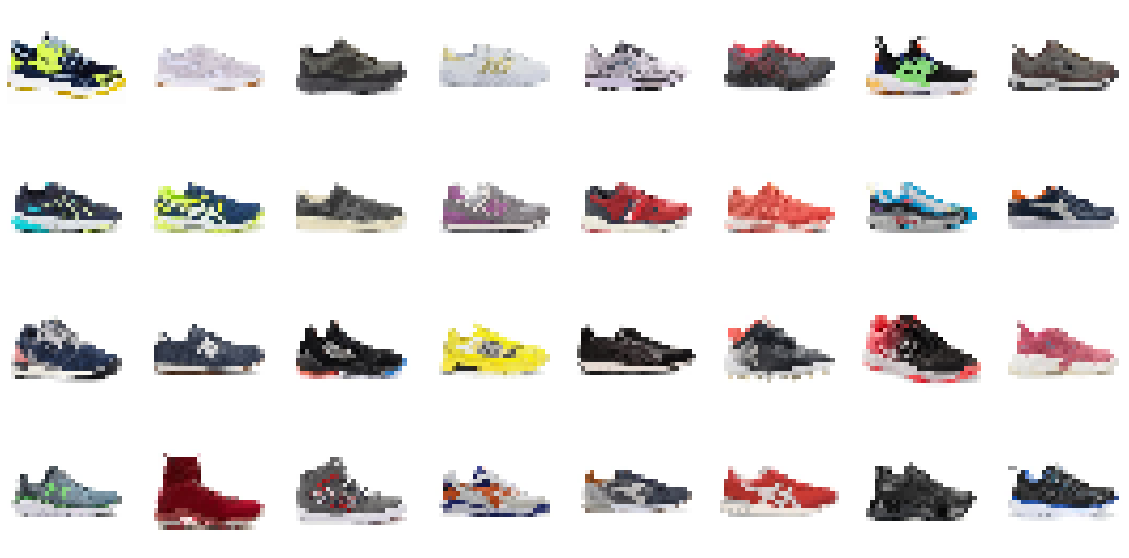

In [11]:
def visualize_images(data, n_rows, n_cols):
    n_samples = n_rows * n_cols

    if len(data) != n_samples:
        sample_indices = np.random.choice(len(data), n_samples, replace=len(data) < n_samples)
    else:
        sample_indices = np.arange(len(data)).astype(int)

    plt.figure(figsize=(int(2.5 * n_cols), int(2.5 * n_rows)))
    for i, sample_index in enumerate(sample_indices):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(data2img(data[sample_index]))
        plt.axis("off")
    plt.show()

# draw random images
visualize_images(sample_data(32), 4, 8)

## Random Noise
Generate a TensorFlow `Tensor` containing gaussian noise of shape `[batch_size, dim]`:

In [12]:
NOISE_SIZE = 100

In [13]:
def sample_noise(batch_size):
    return np.random.randn(batch_size, NOISE_SIZE)

## Fully connected GAN (1 pt)

### Generator (0.5 pt)

Our first step is to build a generator. You should use the layers in `tf.keras.layers` to construct the model. All fully connected layers should include bias terms. Use the default initializers for parameters.

Architecture:
 * Fully connected with output size of 1024
 * ReLU
 * Fully connected with output size of 1024
 * ReLU
 * Fully connected with output size of 28 x 28 x 3
 * Reshape into (28, 28, 3)
 * TanH (to restrict every element of the output to be in the range [-1,1])

In [14]:
def build_fc_generator():
    inputs = L.Input(shape=(NOISE_SIZE,))

    # TODO: build the model
    
    model = keras.Sequential(name="FCGAN_gen")

    model.add(inputs)
    model.add(L.Dense(1024, activation='relu'))
    model.add(L.Dense(1024, activation='relu'))
    model.add(L.Dense(28*28*3))
    model.add(L.Reshape((28, 28, 3)))
    model.add(L.Activation(keras.activations.tanh))

    return model

In [15]:
# Build FCGAN generator
generator = build_fc_generator()
generator.summary()

Model: "FCGAN_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              103424    
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_2 (Dense)              (None, 2352)              2410800   
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 3)         0         
_________________________________________________________________
activation (Activation)      (None, 28, 28, 3)         0         
Total params: 3,563,824
Trainable params: 3,563,824
Non-trainable params: 0
_________________________________________________________________


In [16]:
noise = sample_noise(32)
fake_data = generator.predict(noise)
assert fake_data.shape[1:] == IMAGE_SIZE + (3,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Discriminator (0.5 pt)

Now you are to build a discriminator. Same as for generator, all fully connected layers should include bias terms. You should use the default initializers for parameters here as well.

Architecture:
 * Flatten
 * Fully connected with output size of 256
 * Leaky ReLU(0.01)
 * Fully connected with output size of 256
 * Leaky ReLU(0.01)
 * Fully connected with output size of 1
 * Sigmoid (to obtain logits as an output)

The output of the discriminator should thus have shape `[batch_size, 1]`, and contain real numbers corresponding to the probability that each of the `batch_size` inputs is a real image.

In [17]:
def build_fc_discriminator():
    inputs = L.Input(shape=IMAGE_SIZE + (3,))
    
    model = keras.Sequential(name="FCGAN_disc")

    model.add(inputs)
    model.add(L.Flatten())
    model.add(L.Dense(256))
    model.add(L.LeakyReLU(0.01))
    model.add(L.Dense(256))
    model.add(L.LeakyReLU(0.01))
    model.add(L.Dense(1, activation='sigmoid'))

    return model

In [18]:
# Build FCGAN discriminator
discriminator = build_fc_discriminator()
discriminator.summary()

Model: "FCGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2352)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               602368    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 668,417
Trainable params: 668,417
Non-trainable params: 0
__________________________________________________

In [19]:
fake_probas = discriminator.predict(fake_data)
assert fake_probas.shape[1:] == (1,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## GAN Loss (1 pt)

Compute the generator and discriminator loss. The generator loss is:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Instead of computing the expectation, you may average over elements of the minibatch, so make sure to combine the loss by *averaging* instead of summing.

Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

In [20]:
def generator_gan_loss(y_true, y_pred):
    fake_probas = y_pred
    logp_fake_is_real = K.log(K.epsilon() + fake_probas)
    loss = -K.mean(logp_fake_is_real)
    return loss

In [21]:
loss = generator_gan_loss(None, fake_probas)
assert loss.shape[1:] == ()
K.eval(loss)

0.6296536

In [22]:
def discriminator_gan_loss(y_true, y_pred, eps=K.epsilon()):
    probas = K.clip(y_pred, eps, 1 - eps) # clip to avoid overflow

    is_real = y_true
    is_fake = 1 - y_true

    logp_real_is_real = is_real * K.log(eps + y_pred)
    logp_fake_is_fake = is_fake * K.log(eps + 1 - y_pred)

    loss = K.sum(logp_real_is_real) / (K.sum(is_real) + eps)
    loss += K.sum(logp_fake_is_fake) / (K.sum(is_fake) + eps)
    return -loss

In [23]:
real_data = sample_data(32)

real_and_fake_data = np.concatenate((real_data, fake_data))
real_and_fake_labels = [1] * len(real_data) + [0] * len(fake_data)

real_and_fake_probas = discriminator.predict(real_and_fake_data)

loss = discriminator_gan_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

92.054474

In [24]:
discriminator_opt = keras.optimizers.Adam(0.0002, 0.5)
discriminator_loss = discriminator_gan_loss

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [25]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=discriminator(generator.outputs),
    name="FCGAN_combined"
)

generator_opt = keras.optimizers.Adam(0.0002, 0.5)
generator_loss = generator_gan_loss

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss
)

**Utility functions**

Just a few helper functions that draw current data distributions and sample training batches.

In [27]:
def sample_images(n_rows, n_cols):
    batch_size = n_rows * n_cols
    data = generator.predict(sample_noise(batch_size))
    visualize_images(data, n_rows, n_cols)


def sample_probas(num_samples, batch_size=1):
    plt.title("Fake vs real distribution")
    
    real_probas, fake_probas = [], []
    
    for _ in range(0, num_samples, batch_size):
        real_data = sample_data(batch_size)
        fake_data = generator.predict(sample_noise(batch_size))
        
        real_probas.append(discriminator.predict(real_data))
        fake_probas.append(discriminator.predict(fake_data))

    real_probas = np.concatenate(real_probas, 0)[:num_samples]
    fake_probas = np.concatenate(fake_probas, 0)[:num_samples]

    plt.hist(real_probas, label="D(x)", color='g', alpha=0.5, range=[0,1])
    plt.hist(fake_probas, label="D(G(z))", color='r', alpha=0.5, range=[0,1])
    plt.legend(loc="best")
    plt.show()

### Training
Train generator and discriminator in a loop and draw results once every N iterations.

Epoch: 4900


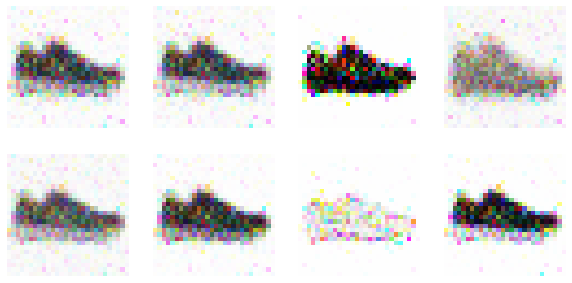

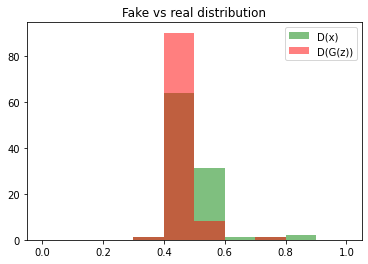

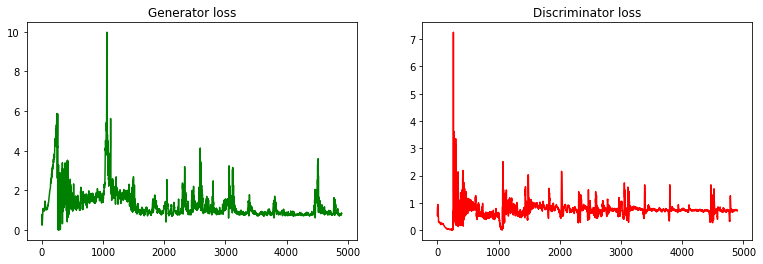

In [33]:
batch_size = 128
epochs = 5000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Generate a new batch of noise
    noise = sample_noise(batch_size)

    # Get a batch of real images
    real_data = sample_data(batch_size)

    # Generate a batch of fake images
    # Hint: use .predict() method
    fake_data = generator.predict(noise)

    # Run discriminator on both real and fake images
    # Hint: use .train_on_batch() method
    loss_d_real = discriminator.train_on_batch(real_data, np.ones([batch_size, 1])) # train on real_data
    loss_d_fake =  discriminator.train_on_batch(fake_data, np.zeros([batch_size, 1])) # train on fake_data
    loss_d = 0.5 * (loss_d_real + loss_d_fake)

    # Make another noise batch
    noise = sample_noise(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Hint: use combined model
    loss_g = combined.train_on_batch(noise, np.ones([batch_size, 1]))

    history["disc"].append(loss_d)
    history["gen"].append(loss_g)

    if epoch % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(2, 4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time, history["gen"], color='g')
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

## Deep Convolutional GANs (2 pts)
In the first part of the notebook, you have implemented an almost direct copy of the original GAN network from Ian Goodfellow. However, this network architecture allows no real spatial reasoning. It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers. Thus, in this section, you are to implement some of the ideas from [DCGAN](https://arxiv.org/abs/1511.06434), where both discriminator and generator are convolutional networks.

### Generator (1 pt)

Architecture:
 * Fully connected with output size of 128x7x7
 * Reshape into (7, 7, 128)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=128, padding="same"
 * Batch Normalization with momentum(0.8)
 * ReLU
 * UpSampling2D(2)
 * Conv2D: 3x3, filters=64, padding="same"
 * Batch Normalization with momentum(0.8)
 * ReLU
 * Conv2D: 3x3, filters=3, padding="same"
 * TanH (to restrict every element of the output to be in the range [-1,1])

In [28]:
def build_dc_generator():
    inputs = L.Input(shape=(NOISE_SIZE,))

    model = keras.Sequential(name="DCGAN_gen")

    model.add(inputs)
    model.add(L.Dense(128 * 7 * 7))
    model.add(L.Reshape((7, 7, 128)))
    model.add(L.Activation('relu'))
    model.add(L.UpSampling2D(2))
    model.add(L.Conv2D(filters=128, kernel_size=3, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Activation('relu'))
    model.add(L.UpSampling2D(2))
    model.add(L.Conv2D(filters=64, kernel_size=3, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Activation('relu'))
    model.add(L.Conv2D(filters=3, kernel_size=3, padding='same'))
    model.add(L.Activation('tanh'))
    
    return model

In [29]:
# Build DCGAN generator
generator = build_dc_generator()
generator.summary()

Model: "DCGAN_gen"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
activation_1 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 128)       0 

In [30]:
noise = sample_noise(32)
fake_data = generator.predict(noise)
assert fake_data.shape[1:] == IMAGE_SIZE + (3,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Discriminator (1  pt)

Architecture:
 * Conv2D: 3x3, filters=32, strides=2, padding="same"
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=64, strides=2, padding="same"
 * Zero Padding: ((0, 1), (0, 1))
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=128, strides=2, padding="same"
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Conv2D: 3x3, filters=256, strides=2, padding="same"
 * Batch Normalization with momentum(0.8)
 * Leaky ReLU(0.2)
 * Dropout(0.25)
 * Flatten
 * Fully connected layer with output size 1
 * Sigmoid

In [31]:
def build_dc_discriminator():
    inputs = L.Input(shape=(IMAGE_SIZE + (3,)))

    model = keras.Sequential(name="DCGAN_disc")

    model.add(inputs)
    model.add(L.Conv2D(32, 3, strides=2, padding ='same'))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(64, 3, strides=2, padding ='same'))
    model.add(L.ZeroPadding2D(((0, 1), (0, 1))))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(128, 3, strides=2, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dropout(0.25))
    model.add(L.Conv2D(256, 3, strides=2, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.LeakyReLU(0.2))
    model.add(L.Dropout(0.25))
    model.add(L.Flatten())
    model.add(L.Dense(1, activation='sigmoid'))

    return model

In [32]:
# Build DCGAN discriminator
discriminator = build_dc_discriminator()
discriminator.summary()

Model: "DCGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 64)          0

In [33]:
fake_probas = discriminator.predict(fake_data)
assert fake_probas.shape[1:] == (1,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


## Least Squares GAN loss (1 pt)
We'll now look at [Least Squares GAN loss](https://arxiv.org/abs/1611.04076), a newer, more stable alternative to the original GAN loss function. For this part, all you have to do is change the loss function and retrain the model. You'll implement equation (9) in the paper, with the generator loss:
$$\ell_G  =  \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right]$$
and the discriminator loss:
$$ \ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right]$$

In [34]:
def generator_ls_loss(y_true, y_pred):
    # Implement Least Squares GAN loss for generator
    loss = K.mean(K.pow(y_pred - 1, 2)) / 2
    return loss

In [35]:
loss = generator_ls_loss(None, K.variable(fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

0.12490783

In [36]:
def discriminator_ls_loss(y_true, y_pred):
    # Implement Least Squares GAN loss for discriminator
    is_real = y_true
    is_fake = 1 - y_true

    sq_err_real_and_1 = is_real * K.pow(y_pred - 1, 2)
    sq_err_fake_and_0 = is_fake * K.pow(y_pred, 2)

    loss = K.sum(sq_err_real_and_1) / (K.sum(is_real) + K.epsilon())
    loss += K.sum(sq_err_fake_and_0) / (K.sum(is_fake) + K.epsilon())

    return 0.5 * loss

In [37]:
real_data = sample_data(32)

real_and_fake_data = np.concatenate((real_data, fake_data))
real_and_fake_labels = np.array([1] * len(real_data) + [0] * len(fake_data))

real_and_fake_probas = discriminator.predict(real_and_fake_data)

loss = discriminator_ls_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

16.00075

Last step is to complile models with proper optimizers and losses:

In [38]:
discriminator_opt = keras.optimizers.Adam(0.0002, 0.5)
discriminator_loss = discriminator_ls_loss

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [39]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=discriminator(generator.outputs),
    name="DCGAN_combined"
)

generator_opt = keras.optimizers.Adam(0.0002, 0.5)
generator_loss = generator_ls_loss

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss
)

### Training

Here, training loop is identical to the one for FCGAN in the previous task: 

Epoch: 4900


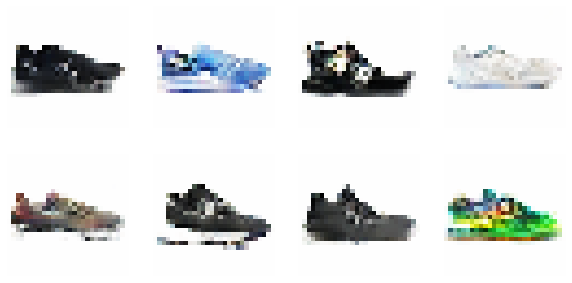

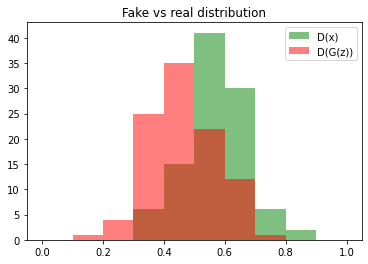

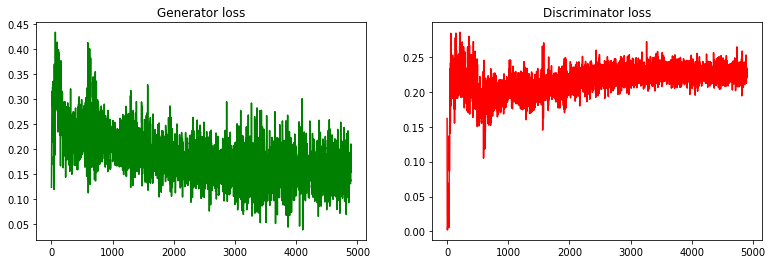

In [78]:
batch_size = 128
epochs = 5000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Generate a new batch of noise
    noise = sample_noise(batch_size)

    # Get a batch of real images
    real_data = sample_data(batch_size)

    # Generate a batch of fake images
    # Hint: use .predict() method
    fake_data = generator.predict(noise)

    # Run discriminator on both real and fake images
    # Hint: use .train_on_batch() method
    real_and_fake_labels = np.array([1] * len(real_data) + [0] * len(fake_data))
    loss_d = discriminator.train_on_batch(np.concatenate((real_data, fake_data)), real_and_fake_labels)

    # Make another noise batch
    noise = sample_noise(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Hint: use combined model
    loss_g = combined.train_on_batch(noise, np.ones(batch_size))

    history["disc"].append(loss_d)
    history["gen"].append(loss_g)

    if epoch % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(2, 4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time, history["gen"], color='g')
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

Save some generated images for evaluation:

In [79]:
all_fake_data = []
for _ in range(0, len(all_data), batch_size):
    fake_data = generator.predict(sample_noise(batch_size))
    all_fake_data.append(fake_data)

all_fake_data = np.concatenate(all_fake_data, 0)[:len(all_data)]
assert all_fake_data.shape == all_data.shape

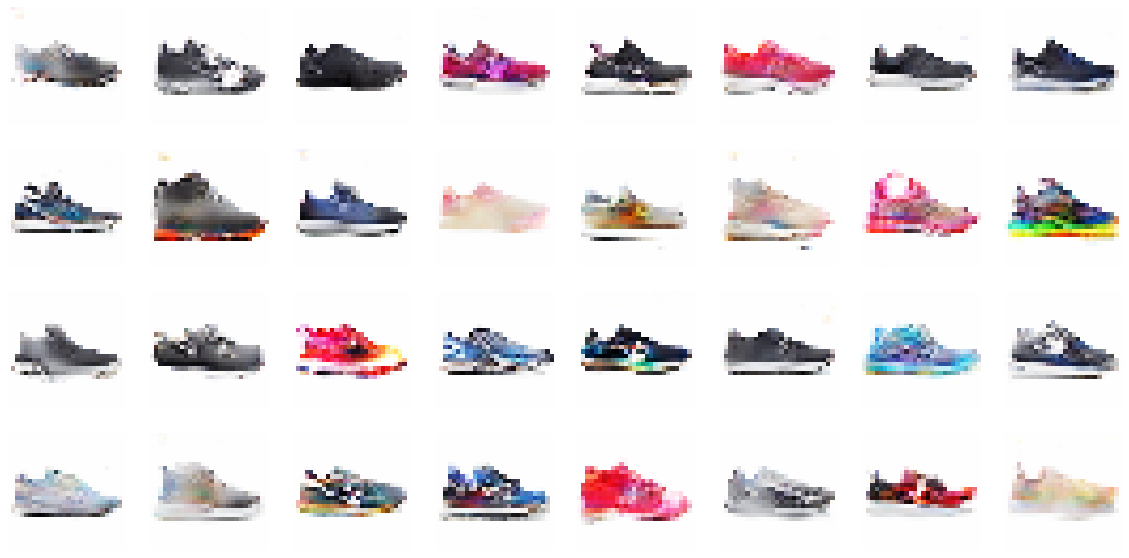

In [80]:
visualize_images(all_fake_data, 4, 8)

In [81]:
np.save("fake_data.npy", all_fake_data)

# II. Super Resolution (3 pts) 

In this part of the notebook you will train a generative model that solves an image-to-image problem, with "small images" as a source domain and "large images" being a target domain. 

To specify the task, you are to **scale small images of 28x28 pixels up to size of 112x112 pixels**.

In [40]:
LOW_RES_SIZE = IMAGE_SIZE
HIGH_RES_SIZE = (112, 112)

In [41]:
all_data_hr = np.stack([
    img2data(load_image(fn, HIGH_RES_SIZE))
    for fn in tqdm.tqdm(image_filenames, position=0)
])
assert all_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

100%|██████████| 5729/5729 [00:05<00:00, 1116.80it/s]


In [42]:
def sample_super_res_data(batch_size, low_res_size=LOW_RES_SIZE, high_res_size=HIGH_RES_SIZE):
    batch_ids = np.random.choice(len(all_data), size=batch_size)
    return all_data[batch_ids], all_data_hr[batch_ids]

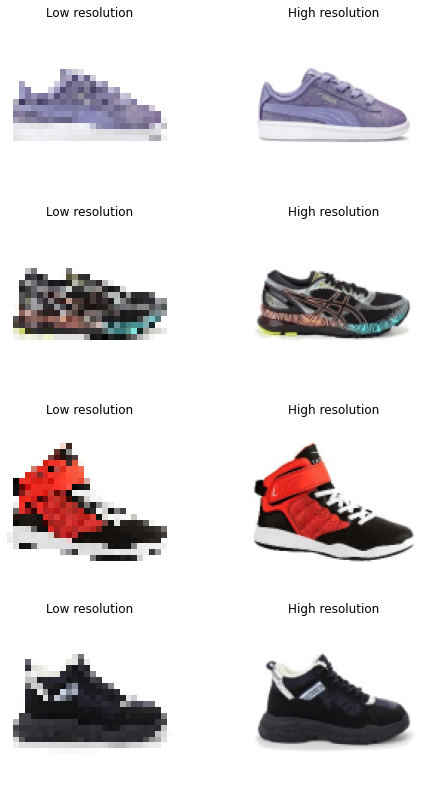

In [43]:
batch_size = 4
real_data_lr, real_data_hr = sample_super_res_data(batch_size)

assert real_data_lr.shape[1:] == LOW_RES_SIZE + (3,)
assert real_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

plt.figure(figsize=(8, 14))
for i in range(batch_size):
    plt.subplot(batch_size, 2, 2 * i + 1)
    plt.title("Low resolution")
    plt.imshow(data2img(real_data_lr[i]))
    plt.axis("off")

    plt.subplot(batch_size, 2, 2 * i + 2)
    plt.title("High resolution")
    plt.imshow(data2img(real_data_hr[i]))
    plt.axis("off")

plt.show()

In the second part of this task, you are to train an [SRGAN](https://arxiv.org/abs/1609.04802)-like model. For your convinience, some layers are already implemented. Now it's your turn -- fill the gaps so the model passes the asserts below.

### Generator (1.5 pts)

To build a SRGAN Generator, you will need a basic Residual Block(filters):

* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU
* Batch Normalization with momentum(0.8)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* Batch Normalization with momentum(0.8)
* Sum up outputs with inputs

In [92]:
def residual_block(inputs, filters, **kwargs):
    model = keras.Sequential()

    model.add(L.Conv2D(filters, (3, 3), activation='relu', strides=1, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    model.add(L.Conv2D(filters, (3, 3), strides=1, padding='same'))
    model.add(L.BatchNormalization(momentum=0.8))
    
    outputs = L.Add()([model(inputs), inputs])
    
    return outputs

... and an Upsampling Block(filters):

* UpSampling2D(2)
* Conv2D: 3x3, filters=filters, strides=1, padding="same"
* ReLU

In [93]:
def up_block(inputs, filters, **kwargs):
    model = keras.Sequential()
    
    model.add(L.UpSampling2D(2))
    model.add(L.Conv2D(filters, (3, 3), activation='relu', strides=1, padding='same'))

    outputs = model(inputs)
    
    return outputs

Now, using these basic building blocks, one is able to define a SRGAN generator:

In [94]:
def build_sr_generator():
    inputs = L.Input(shape=LOW_RES_SIZE + (3,))

    # An initial conv block
    x = L.Conv2D(64, kernel_size=9, strides=1, padding="same")(inputs)
    x = L.ReLU()(x)

    conv = x

    # 16 residual blocks with filters=64
    for block_num in range(16):
        x = residual_block(x, filters=64)

    # A post-residual block
    x = L.Conv2D(64, kernel_size=3, strides=1, padding="same")(x)
    x = L.BatchNormalization(momentum=0.8)(x)

    # Sum up current 'x' with 'conv' obtained earlier
    x = L.Add()([x, conv])

    # Two upsampling blocks with filters=256
    x = up_block(x, filters=256)
    x = up_block(x, filters=256)

    # Final conv block
    x = L.Conv2D(3, kernel_size=9, strides=1, padding="same")(x)
    outputs = L.Activation("tanh")(x)
    
    return keras.models.Model(inputs=inputs, outputs=outputs, name="SRGAN_gen")

In [95]:
# Build SRGAN generator
generator = build_sr_generator()
generator.summary()

Model: "SRGAN_gen"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_142 (Conv2D)             (None, 28, 28, 64)   15616       input_11[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 28, 28, 64)   0           conv2d_142[0][0]                 
__________________________________________________________________________________________________
sequential (Sequential)         multiple             74368       re_lu_3[0][0]                    
__________________________________________________________________________________________

In [96]:
real_data_lr, real_data_hr = sample_super_res_data(32)
fake_data_hr = generator.predict(real_data_lr)
assert fake_data_hr.shape[1:] == HIGH_RES_SIZE + (3,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Discriminator (1.5 pts)

First, define a Discriminator Block(filters, strides):

* Conv2D: 3x3, filters=filters, strides=strides, padding="same"
* Leaky ReLU(0.2)
* (optional) Batch Normalization with momentum(0.8) 

In [97]:
def d_block(inputs, filters, strides=1, apply_batchnorm=True, **kwargs):
    model = keras.Sequential()
    
    model.add(L.Conv2D(filters, (3, 3), strides=strides, padding='same'))
    model.add(L.LeakyReLU(0.2))
    model.add(L.LeakyReLU(0.2))
    if apply_batchnorm:
        model.add(L.BatchNormalization(momentum=0.8))

    outputs = model(inputs)
    return outputs

Now, use this block to build up SRGAN discriminator:

* DBlock(filters=64, strides=1) with Batch Normalization
* DBlock(filters=64, strides=2)
* DBlock(filters=128, strides=1)
* DBlock(filters=128, strides=2)
* DBlock(filters=256, strides=1)
* DBlock(filters=256, strides=2)
* DBlock(filters=512, strides=1)
* DBlock(filters=512, strides=2)
* Flatten
* Fully connected with output size of 1024
* Leaky ReLU(0.2)
* Fully connected with output size of 1
* Sigmoid

In [98]:
def build_sr_discriminator():
    inputs = L.Input(shape=HIGH_RES_SIZE + (3,))

    # TODO: build the model
    filters_arr = [64, 64, 128, 128, 256, 256, 512, 512]
    strides_arr = [1, 2, 1, 2, 1, 2, 1, 2]
    
    x = inputs
    for i, (filters, strides) in enumerate(zip(filters_arr, strides_arr)):
        x = d_block(x, filters=filters, strides=strides, apply_batchnorm=i==0)

    x = L.Flatten()(x)
    x = L.Dense(1024)(x)
    x = L.LeakyReLU(0.2)(x)
    outputs = L.Dense(1, activation='sigmoid')(x)

    return keras.models.Model(inputs=inputs, outputs=outputs, name="SRGAN_disc")

In [99]:
# Build SRGAN discriminator
discriminator = build_sr_discriminator()
discriminator.summary()

Model: "SRGAN_disc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 112, 112, 3)]     0         
_________________________________________________________________
sequential_18 (Sequential)   multiple                  2048      
_________________________________________________________________
sequential_19 (Sequential)   multiple                  36928     
_________________________________________________________________
sequential_20 (Sequential)   multiple                  73856     
_________________________________________________________________
sequential_21 (Sequential)   multiple                  147584    
_________________________________________________________________
sequential_22 (Sequential)   multiple                  295168    
_________________________________________________________________
sequential_23 (Sequential)   multiple                  5

In [100]:
fake_probas = discriminator.predict(fake_data_hr)
assert fake_probas.shape[1:] == (1,)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [101]:
real_data_lr, real_data_hr = sample_super_res_data(32)
real_probas = discriminator.predict(real_data_hr)

real_data = sample_data(32)

real_and_fake_data_hr = np.concatenate((real_data_hr, fake_data_hr))
real_and_fake_labels = np.array([1] * len(real_data_hr) + [0] * len(fake_data_hr))

real_and_fake_probas = discriminator.predict(real_and_fake_data_hr)

loss = discriminator_ls_loss(K.variable(real_and_fake_labels), K.variable(real_and_fake_probas))
assert loss.shape[1:] == ()
K.eval(loss)

16.000698

Typically, SRGAN is trained with additional loss on features from pretrained VGG-19. However, you task will be a bit simplier: use **mean squared error** between real and fake data instead.

In [102]:
def feature_loss(real_features, fake_features):
    # Implement MSE
    loss = K.mean(K.pow(real_features - fake_features, 2))
    return loss

In [103]:
loss = feature_loss(K.variable(real_data_hr), K.variable(fake_data_hr))
assert loss.shape == ()
K.eval(loss)

2.0402915

In [104]:
discriminator_opt = keras.optimizers.Adam(1e-3, 0.5)
discriminator_loss = discriminator_ls_loss # you may choose any or try both. 
#By default, opt for the Least Squares GAN loss.

discriminator.compile(
    optimizer=discriminator_opt,
    loss=discriminator_loss
)

In [105]:
# we only want to be able to train generation for the combined model
discriminator.trainable = False

outputs = generator.outputs

combined = keras.models.Model(
    inputs=generator.inputs,
    outputs=[outputs, discriminator(outputs)], # you should return both probas AND generated images
    name="SRGAN_combined"
)

generator_opt = keras.optimizers.Adam(1e-4, 0.5)
generator_loss = [feature_loss, generator_ls_loss] # mind the order of outputs -- it should match the losses
loss_weights = [0.8, 0.57]

combined.compile(
    optimizer=generator_opt,
    loss=generator_loss,
    loss_weights=loss_weights
)

In [106]:
def sample_images(n_samples):
    batch_size = n_samples
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)
    fake_data_hr = generator.predict(real_data_lr)

    plt.figure(figsize=(11, int(3.5 * n_samples)))
    for i in range(batch_size):
        plt.subplot(n_samples, 3, 3 * i + 1)
        plt.title("Original LR")
        plt.imshow(data2img(real_data_lr[i]))
        plt.axis("off")

        plt.subplot(n_samples, 3, 3 * i + 3)
        plt.title("Generated HR")
        plt.imshow(data2img(fake_data_hr[i]))
        plt.axis("off")
        
        plt.subplot(n_samples, 3, 3 * i + 2)
        plt.title("Real HR")
        plt.imshow(data2img(real_data_hr[i]))
        plt.axis("off")

    plt.show()


def sample_probas(num_samples, batch_size):
    plt.title("Fake vs real distribution")
    
    real_probas, fake_probas = [], []

    for i in range(0, num_samples, batch_size):
        real_data_lr, real_data_hr = sample_super_res_data(batch_size)
        fake_data_hr = generator.predict(real_data_lr)
        
        real_probas.append(discriminator.predict(real_data_hr))
        fake_probas.append(discriminator.predict(fake_data_hr))

    real_probas = np.concatenate(real_probas, 0)[:num_samples]
    fake_probas = np.concatenate(fake_probas, 0)[:num_samples]

    plt.hist(real_probas, label="D(x)", alpha=0.5, range=[0,1], color='g')
    plt.hist(fake_probas, label="D(G(z))", alpha=0.5, range=[0,1], color='r')
    plt.legend(loc="best")
    plt.show()

### Training

Epoch: 2900


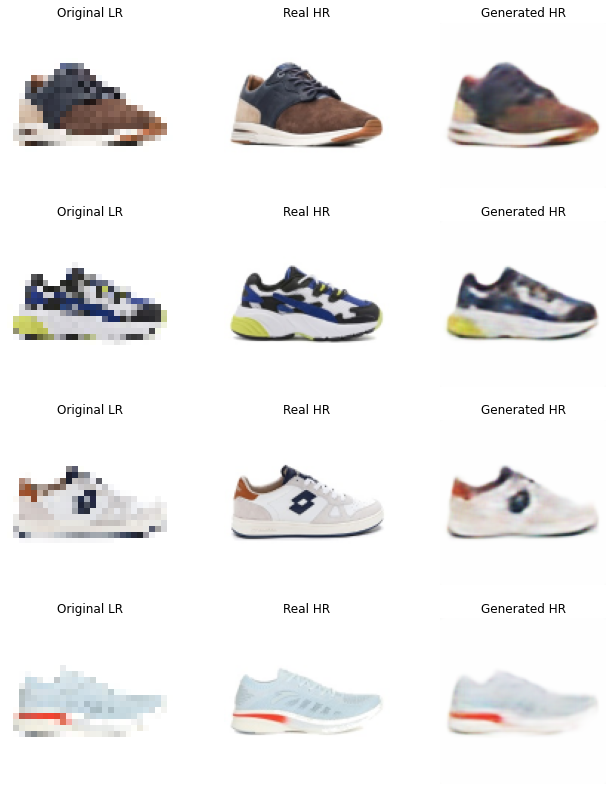

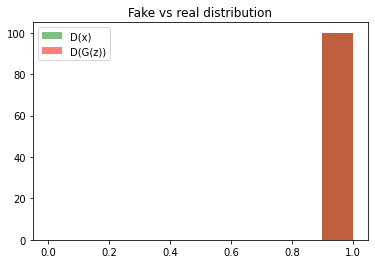

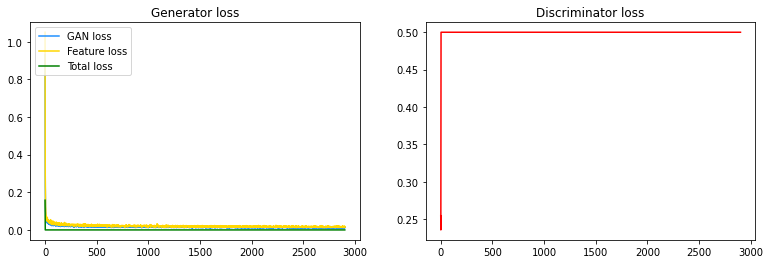

In [ ]:
batch_size = 16
epochs = 5000

history = {"gen": [], "disc": []}

for epoch in range(epochs):

    # Sample low-res and high-res data
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)

    # Generate high resolution images from low resolution ones
    fake_data_hr = generator.predict(real_data_lr)

    # Run discriminator on both real and fake high resolution images
    real_and_fake_labels = np.array([1] * len(real_data_hr) + [0] * len(fake_data_hr))
    loss_d = discriminator.train_on_batch(np.concatenate((real_data_hr, fake_data_hr)), real_and_fake_labels)


    # Sample another batch of low-res and high-res data
    real_data_lr, real_data_hr = sample_super_res_data(batch_size)

    # Train the generator to trick the discriminator
    # For the generator, we want all the {fake, not-fake} labels 
    # to say not-fake
    # Mind the number and the order of the outputs of the combined model!
    loss_g = combined.train_on_batch(real_data_lr, [real_data_hr, np.ones((batch_size, 1))])

    history["gen"].append(loss_g) 
    history["disc"].append(loss_d)

    if epoch % 100 == 0:
        clear_output(wait=True)
        print("Epoch:", epoch)
        
        sample_images(4)
        sample_probas(100, batch_size)

        time = np.arange(epoch + 1)

        fig, ax = plt.subplots(ncols=2, figsize=(13, 4))
        ax[0].set_title("Generator loss")
        ax[0].plot(time, [_[0] for _ in history["gen"]], color="dodgerblue", label="GAN loss")
        ax[0].plot(time, [_[1] for _ in history["gen"]], color="gold", label="Feature loss")
        ax[0].plot(time, [_[2] for _ in history["gen"]], color='g', label="Total loss")
        ax[0].legend(loc="upper left")
        ax[1].set_title("Discriminator loss")
        ax[1].plot(time, history["disc"], color='r')
        plt.show()

Save some fake high resolution images generated from real low resolution samples stored in `all_data`:

In [ ]:
all_fake_data_from_real_lr = []
for index in tqdm.trange(0, len(all_data), batch_size, position=0):
    real_data_lr, real_data_hr = sample_super_res_data(batch_size) 
    fake_data_hr = generator.predict(real_data_lr)
    all_fake_data_from_real_lr.append(fake_data_hr)

all_fake_data_from_real_lr = np.concatenate(all_fake_data_from_real_lr, 0)[:len(all_data)]
assert all_fake_data_from_real_lr.shape == all_data_hr.shape

In [ ]:
visualize_images(all_fake_data_from_real_lr, 4, 8)

In [ ]:
np.save("fake_data_from_real_lr.npy", all_fake_data_from_real_lr)

Now save some fake high resolution images generated from fake low resolution samples stored in `all_fake_data`:

In [ ]:
try:
    all_fake_data
except:
    all_fake_data = np.load("fake_data.npy")

In [ ]:
all_fake_data_from_fake_lr = []
for index in tqdm.trange(0, len(all_data), batch_size, position=0):
    fake_data_lr = all_fake_data[index:index + batch_size]
    fake_data_hr = generator.predict(fake_data_lr)
    all_fake_data_from_fake_lr.append(fake_data_hr)

all_fake_data_from_fake_lr = np.concatenate(all_fake_data_from_fake_lr, 0)[:len(all_data)]
assert all_fake_data_from_fake_lr.shape == all_data_hr.shape

In [ ]:
visualize_images(all_fake_data_from_fake_lr, 4, 8)

In [ ]:
np.save("fake_data_from_fake_lr.npy", all_fake_data_from_fake_lr)

# III. GAN metrics (2 pts)

There exists a few metrics used to measure GAN performance. Some of them are based on comparing real samples against generated ones, while the other rely on additional pretrained models that are applied to both real and generated data in order to accumulate high-level statistics. In this task, you are going to use two metrics representing these two approaches -- namely, [Precision-Recall Density](https://arxiv.org/pdf/1806.00035) and [Fréchet Inception Distance](https://arxiv.org/pdf/1706.08500). 

### Precision-Recall Density (PRD score) (1 pt)

Your first task is to implement [Precision-Recall Density](https://arxiv.org/pdf/1806.00035.pdf) score.

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans

def bin_counts(real_data, fake_data, n_bins=25):
    real_data = real_data.reshape(len(real_data), -1)
    fake_data = fake_data.reshape(len(fake_data), -1)

    data = np.vstack([real_data, fake_data])

    kmeans = MiniBatchKMeans(n_clusters=n_bins, n_init=10).fit(data)
    
    real_labels = kmeans.labels_[:len(real_data)]
    fake_labels = kmeans.labels_[len(real_data):]

    real_density = np.histogram(real_labels, bins=n_bins, range=[0, n_bins], density=True)[0]
    fake_density = np.histogram(fake_labels, bins=n_bins, range=[0, n_bins], density=True)[0]
    
    return real_density, fake_density

In [ ]:
import math
from sklearn.metrics import auc

def calculate_alpha_beta(real_density, fake_density, n_thetas=1000):
    assert real_density.shape == fake_density.shape
    
    alpha = []
    beta = []
    
    thetas = np.linspace(1e-6, np.pi / 2 - 1e-6, num=n_thetas)
    for theta in thetas:
        tan = math.tan(theta)
        alpha.append("???")
        beta.append("???")
    
    return alpha, beta

def calculate_precision_recall_density(real_densities, fake_densities, repeat_number=1000):
    vectors = np.array([
       calculate_alpha_beta(real_densities, fake_densities)
       for _ in range(repeat_number)
    ]).mean(axis=0)
    return vectors


def calculate_prd_score(real_data, fake_data):
    # Calculate bin counts from real and generated data
    real_density, fake_density = "???"

    plt.bar(range(len(real_density)), real_density, width=1, color='g', alpha=0.5, label="Real density")
    plt.bar(range(len(fake_density)), fake_density, width=1, color='r', alpha=0.5, label="Fake density")
    plt.legend()
    plt.show()

    # Calculate alpha and beta
    alpha, beta = "???"
    
    # Calculate area under curve (AUC) for alpha and beta
    score = "???"

    return score, alpha, beta

Calculate PRD score for DCGAN (task I). You should pass `all_data` and `all_fake_data` to scoring function.

In [ ]:
score,  _, _ = calculate_prd_score(all_data, all_fake_data)
print("Score:", score)

Now use PRD score to compare high resolution data generated from real low resolution data (`all_fake_data_from_real_lr`) and fake resolution data (`all_fake_data_from_fake_lr`):

In [ ]:
print("Generated from real LR")
score_real, alpha_real, beta_real = calculate_prd_score(all_data_hr, all_fake_data_from_real_lr)
print("Score:", score_real, end='\n\n')

print("Generated from fake LR")
score_fake, alpha_fake, beta_fake = calculate_prd_score(all_data_hr, all_fake_data_from_fake_lr)
print("Score:", score_fake, end='\n\n')

fig, ax = plt.subplots(figsize=(8, 8))
ax.tick_params(axis="both", which="major", labelsize=8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(alpha_real, beta_real, color='g', label="Generated from real LR")
plt.plot(alpha_fake, beta_fake, color='r', label="Generated from fake LR")
plt.legend()
plt.show()

### Fréchet Inception Distance (FID score) (1 pt)

[Frechet Inception Distance](https://arxiv.org/pdf/1706.08500) is an improved version of [Inception score](https://arxiv.org/abs/1606.03498), that additionally calculates the statistics of real data and compares it to the statistics of generated data. It is probably the most widely-used option for evaluating GANs, and relies on features extracted with [InceptionV3](https://arxiv.org/abs/1512.00567) pretrained on ImageNet. These features assumed to come from a multivariate Gaussian distribution, so Fréchet distance between two multivariate Gaussians can be calculated:

$$\text{FID} = ||\mu_r - \mu_g||^2 + \text{Tr} (\Sigma_r + \Sigma_g - 2 (\Sigma_r \Sigma_g)^{1/2}),$$

where $X_r \sim \mathcal{N} (\mu_r, \Sigma_r)$ and $X_g \sim \mathcal{N} (\mu_g, \Sigma_g)$ are the 2048-dimensional activations of the Inception-v3 pool3 layer for real and generated samples respectively.

First, create InceptionV3 model. As you will be using it for feature extraction only, you should set `include_top=False` and `pooling="avg"`:

In [ ]:
base_inception = keras.applications.inception_v3.InceptionV3(weights="imagenet",
                                                             include_top="???",
                                                             pooling="???")
inputs = L.Input(shape=(112, 112, 3))
outputs = base_inception(L.UpSampling2D(2)(inputs))

inception = keras.models.Model(inputs=inputs, outputs=outputs)
inception.trainable = False

In [ ]:
real_data_lr, real_data_hr = sample_super_res_data(32)
assert inception.predict(real_data_hr).shape[1:] == (2048,)

In [ ]:
def calculate_activations(data, batch_size=32, verbose=False):
    # Calculate activations of Pool3 layer of InceptionV3
    if verbose:
        print("Calculating activations...")
    activations = inception.predict(data, batch_size=batch_size, verbose=verbose)
    return activations

def calculate_activation_statistics(activations):
    # Calculate mean and covariance of activations. Mind the dimensions!
    mu = "???"
    sigma = "???"
    return mu, sigma

In [ ]:
real_activations = calculate_activations(all_data_hr, verbose=True)
real_mu, real_sigma = calculate_activation_statistics(real_activations)

assert real_mu.shape == (2048,)
assert real_sigma.shape == (2048, 2048)

In [ ]:
import scipy

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    assert mu1.shape == mu2.shape
    assert sigma1.shape == sigma2.shape

    sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1, sigma2))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(sigma1_sigma2):
        sigma1_sigma2 = sigma1_sigma2.real

    # Product might be almost singular
    if not np.isfinite(sigma1_sigma2).all():
        offset = np.eye(sigma1.shape[0]) * eps
        sigma1_sigma2 = scipy.linalg.sqrtm(np.dot(sigma1 + offset, sigma2 + offset))

    diff = mu1 - mu2
    return "???" # use diff, sigma1, sigma2 to calculate FID according to the formula above


def calculate_fid_score(real_data, fake_data, verbose=False):
    # Run inception on real and fake data to obtain activations
    real_activations = "???"
    fake_activations = "???"

    # Calculate mu and sigma for both real and fake activations
    real_mu, real_sigma = "???"
    fake_mu, fake_sigma = "???"

    return "???" # calculate Frechet distance

Calculate FID score between `all_data_hr` and `all_fake_data_from_real_hr`:

In [ ]:
score = calculate_fid_score(all_data_hr, all_fake_data_from_real_lr)
print("Score:", score)

Putting it all together: calculate FID score between `all_data_hr` and `all_fake_data_from_fake_hr`:

In [ ]:
score = calculate_fid_score(all_data_hr, all_fake_data_from_fake_lr)
print("Score:", score)